In [134]:
import datetime
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Timestamp as ts
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

In [135]:
%matplotlib inline

In [136]:
Path.cwd()

PosixPath('/Users/jwt/PycharmProjects/cpi_program/WDBA2023')

In [137]:
today = datetime.datetime.today()
input_file = Path.cwd() / 'data_files' / 'wdba_stats_processed_2022_2023Jun-04-23.csv'
report_dir = Path.cwd() / 'reports'
report_file = report_dir / f"WDBA_Stats_{today:%b-%d-%y}.xlsx"


In [138]:
# Helper function to annualize projections
def annualized_projection(value: int, num_months: int) -> int:
    """
    Annualize projections given a value and elapsed months

    Parameters
    ----------
    value : int
        Value to be annualized
    num_months : int
        Number of months elapsed
    """
    return int(round(value * (12 / num_months), 0))

In [139]:
df = pd.read_csv(input_file, parse_dates=['date_filed', "date_reopened", "date_terminated"],
                 dtype={'group': 'category', 'is_prose': 'category'})

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   case_number       1624 non-null   object        
 1   judge             1624 non-null   object        
 2   date_filed        1624 non-null   datetime64[ns]
 3   date_reopened     92 non-null     datetime64[ns]
 4   date_terminated   1065 non-null   datetime64[ns]
 5   NOS               1624 non-null   int64         
 6   IsProse           1624 non-null   object        
 7   group             1624 non-null   category      
 8   is_prose          1624 non-null   category      
 9   statistical_year  1624 non-null   int64         
dtypes: category(2), datetime64[ns](3), int64(2), object(3)
memory usage: 105.5+ KB


In [141]:
df.head()

,case_number,judge,date_filed,date_reopened,date_terminated,NOS,IsProse,group,is_prose,statistical_year
0,3:21-cv-00217-jdp,jdp,2021-04-01,NaT,2022-07-26,751,n,Labor,counseled,2022
1,3:21-cv-00218-wmc,wmc,2021-04-01,NaT,2022-01-03,863,n,Social Security,counseled,2022
2,3:21-cv-00215-wmc,wmc,2021-04-01,NaT,2023-01-31,550,y,Prisoner Petitions,prose,2022
3,3:21-cv-00219-jdp,jdp,2021-04-01,NaT,2021-11-30,864,n,Social Security,counseled,2022
4,3:21-cv-00220-wmc,wmc,2021-04-02,NaT,2022-09-02,330,n,Torts/Personal Injury,counseled,2022


In [142]:
df.tail()

,case_number,judge,date_filed,date_reopened,date_terminated,NOS,IsProse,group,is_prose,statistical_year
1619,3:20-cv-00098-wmc,wmc,2020-01-31,2023-01-25,2023-05-12,830,n,Intellectual Property Rights,counseled,2023
1620,3:20-cv-00019-jdp,jdp,2020-01-09,2023-02-13,NaT,830,n,Intellectual Property Rights,counseled,2023
1621,3:18-cv-01003-wmc,wmc,2018-12-04,2023-02-24,NaT,550,y,Prisoner Petitions,prose,2023
1622,3:18-cv-00116-wmc,wmc,2018-02-19,2023-03-24,NaT,550,y,Prisoner Petitions,prose,2023
1623,3:20-cv-00242-wmc,wmc,2020-03-18,2023-03-31,NaT,442,n,Civil Rights,counseled,2023


In [143]:
case_breakdown_pro_se_vs_counseled = df.groupby(['statistical_year', 'is_prose'])['case_number'].count()

In [144]:
case_breakdown_pro_se_vs_counseled.unstack()

is_prose,counseled,prose
statistical_year,,
2022,473,354
2023,419,378


In [145]:
pd.crosstab(df['statistical_year'],
            df['is_prose'],
            aggfunc='count',
            values=df['case_number'],
            margins=True,
            margins_name='Total',
            normalize='index')

is_prose,counseled,prose
statistical_year,,
2022,0.571947,0.428053
2023,0.525721,0.474279
Total,0.549261,0.450739


In [146]:
pd.pivot_table(df,
               index=['statistical_year'],
               columns=['is_prose'],
               values=['case_number'],
               aggfunc='count',
               margins=True,
               margins_name='Total',
               fill_value=0,
               dropna=False,
               observed=False)

case_number            
is_prose           counseled prose Total
statistical_year                        
2022                     473   354   827
2023                     419   378   797
Total                    892   732  1624

In [175]:
df['group'] = df['group'].apply(lambda x: 'Prisoner Petitions' if x == 'Habeas Corpus' else x)
df['group'] = df['group'].apply(lambda x: 'Torts/Personal Injury' if x == 'Personal Property' else x)

In [176]:
nos_totals_by_year = pd.crosstab(df['group'],
                                 df['statistical_year'],
                                 aggfunc='count',
                                 values=df['case_number'],
                                 margins=True,
                                 margins_name='Total')

In [149]:
# Annualize projections for 2023
# nos_totals_by_year.loc[2023,:] = nos_totals_by_year.loc[2023,:].apply(lambda x: annualized_projection(x, 11))

In [177]:
nos_totals_by_year

statistical_year,2022,2023,Total
group,,,
Bankruptcy,5,4,9
Civil Rights,134,146,280
Contract,53,49,102
Federal Tax Suits,3,7,10
Forfeiture/Penalty,5,7,12
Immigration,8,9,17
Intellectual Property Rights,29,31,60
Labor,51,51,102
Other Statutes,89,46,135


In [186]:
nos_totals_by_year = pd.crosstab(df['group'],
                                 df['statistical_year'],
                                 aggfunc='count',
                                 values=df['case_number'],
                                 margins=False)

In [187]:
nos_totals_by_year

statistical_year,2022,2023
group,,
Bankruptcy,5,4
Civil Rights,134,146
Contract,53,49
Federal Tax Suits,3,7
Forfeiture/Penalty,5,7
Immigration,8,9
Intellectual Property Rights,29,31
Labor,51,51
Other Statutes,89,46


In [179]:
pct_change = nos_totals_by_year.pct_change(axis='columns')

In [180]:
pct_change

statistical_year,2022,2023,Total
group,,,
Bankruptcy,NaN,-0.200000,1.250000
Civil Rights,NaN,0.089552,0.917808
Contract,NaN,-0.075472,1.081633
Federal Tax Suits,NaN,1.333333,0.428571
Forfeiture/Penalty,NaN,0.400000,0.714286
Immigration,NaN,0.125000,0.888889
Intellectual Property Rights,NaN,0.068966,0.935484
Labor,NaN,0.000000,1.000000
Other Statutes,NaN,-0.483146,1.934783


In [190]:
round(pct_change.loc[:, 2023] * 100, 2)

group
Bankruptcy                      -20.00
Civil Rights                      8.96
Contract                         -7.55
Federal Tax Suits               133.33
Forfeiture/Penalty               40.00
Immigration                      12.50
Intellectual Property Rights      6.90
Labor                             0.00
Other Statutes                  -48.31
Prisoner Petitions               -1.39
Real Property                   160.00
Social Security                  14.46
Torts/Personal Injury           -25.68
Total                            -3.63
Name: 2023, dtype: float64

In [156]:
pct_change[2023].values



array([-0.2       ,  0.08955224, -0.0754717 ,  1.33333333,  0.4       ,
        0.125     ,  0.06896552,  0.        , -0.48314607, -0.14285714,
       -0.01388889,  1.6       ,  0.14457831, -0.28333333])

In [157]:
stats = pd.read_csv('/Users/jwt/PycharmProjects/cpi_program/WDBA2023/data_files/wdba_stats_processed_Jun-05-23.csv',
                    parse_dates=['date_filed', "date_reopened", "date_terminated"],
                    dtype={'group': 'category', 'is_prose': 'category'})

In [158]:
total_cases = pd.pivot_table(stats, index=['statistical_year'], aggfunc='count', values=['case_number'])

In [159]:
stats.tail()

,case_number,judge,date_filed,date_reopened,date_terminated,NOS,IsProse,group,is_prose,statistical_year
4779,3:17-cv-00435-wmc,wmc,2017-06-05,2021-04-08,2022-06-22,540,n,Prisoner Petitions,counseled,2022
4780,3:17-cv-00552-wmc,wmc,2017-07-17,2021-05-06,2022-08-18,550,y,Prisoner Petitions,prose,2022
4781,3:17-cv-00231-bbc,bbc,2017-03-22,2021-06-02,2021-06-02,530,n,Habeas Corpus,counseled,2022
4782,3:17-cv-00524-wmc,wmc,2017-07-06,2021-07-08,2022-04-28,550,y,Prisoner Petitions,prose,2022
4783,3:16-cv-00229-wmc,wmc,2016-04-11,2021-10-04,NaT,530,y,Habeas Corpus,prose,2022


In [160]:
total_cases

,case_number
statistical_year,
2019,1066
2020,1104
2021,1028
2022,807
2023,779


## Plots


In [161]:
# Colorblind-friendly colors
colors = [[0, 0, 0], [230 / 255, 159 / 255, 0], [86 / 255, 180 / 255, 233 / 255], [0, 158 / 255, 115 / 255],
          [213 / 255, 94 / 255, 0], [0, 114 / 255, 178 / 255]]


In [162]:
x = total_cases['case_number']
y = total_cases.index

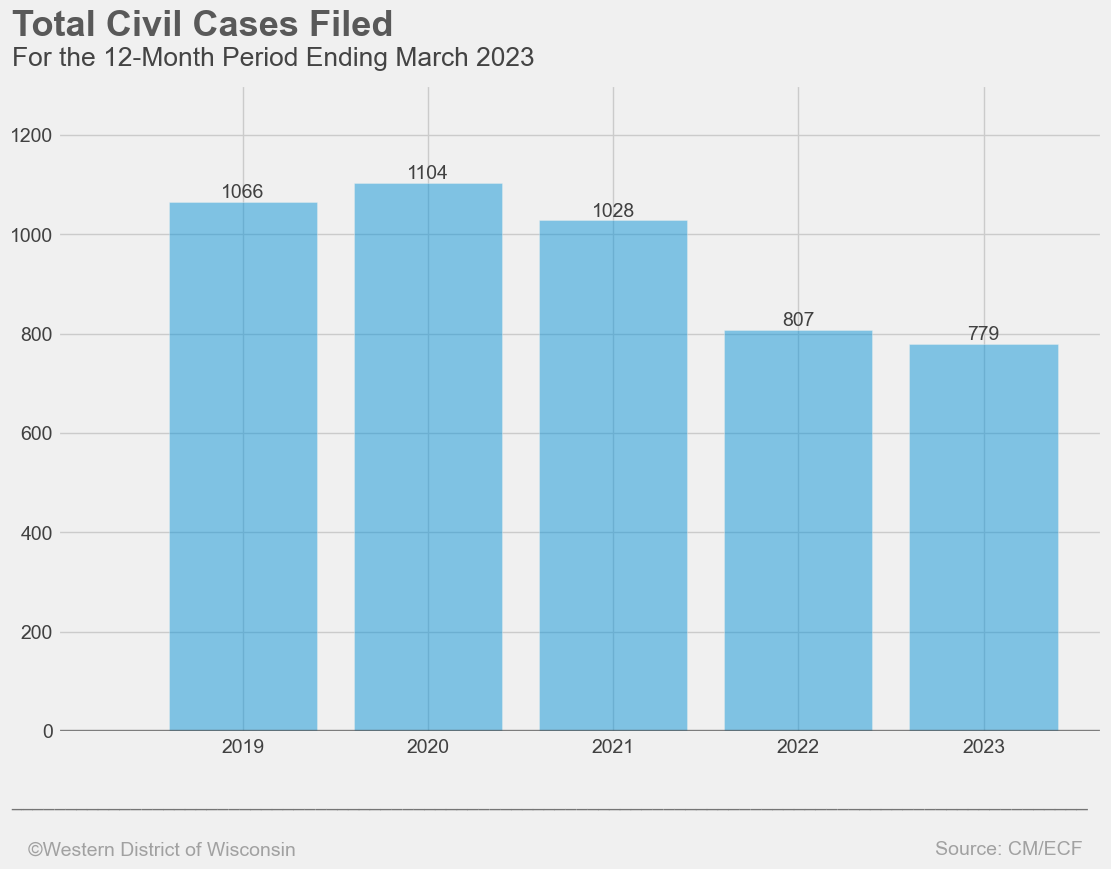

In [257]:
fig, ax = plt.subplots(figsize=(12, 8))
style.use('fivethirtyeight')
bar_width = 0.8
for (total, year) in zip(x, y):
    p = ax.bar(year,
               # using the Case ID data
               total,
               # set the width
               width=bar_width,
               # with the label Case Year
               label=year,
               # with alpha 0.5
               alpha=0.5,
               # with color
               color='#0F95D7')
    ax.bar_label(p, label_type='edge', fontsize=14, color='#414141')
# Y axis past 0 & above 100 -- grid line will pass 0 & 100 marker
plt.ylim(-5, 1300)
# Bolded horizontal line at y=0
ax.axhline(y=0, color='#414141', linewidth=1.7, alpha=.7)

# Y-labels to only these
ax.set_yticks([0, 200, 400, 600, 800, 1000, 1200])
ax.set_yticklabels(labels=['0', '200', '400', '600', '800', '1000', '1200'], fontsize=14, color='#414141')

# X-labels and changing label names
ax.set_xticks([2019, 2020, 2021, 2022, 2023])
ax.set_xticklabels(['2019', '2020', '2021', '2022', '2023'], fontsize=14, color='#414141')

# create more vertical space
plt.xlim(left=2018)

# Title and Subtitle
ax.text(x=2017.75, y=1400, s="Total Civil Cases Filed", fontsize=26, weight='bold', alpha=.75)
ax.text(x=2017.75, y=1340, s="For the 12-Month Period Ending March 2023", fontsize=19, alpha=.85)

# Signature bar
ax.text(x=2017.75, y=-150,
        s='___________________________________________________________________________________________________',
        color='#414141', alpha=.7)
# Footer
ax.text(x=2017.75, y=-250,
        s='   ©Western District of Wisconsin', fontsize=14, color='grey', alpha=.7)

ax.text(x=2022.65, y=-250,
        s='   Source: CM/ECF', fontsize=14, color='grey', alpha=.7);

plt.savefig('/Users/jwt/PycharmProjects/cpi_program/WDBA2023/figures/total_cases.png', dpi=300, bbox_inches='tight', transparent=True)

In [185]:
nos_totals_by_year.columns


Int64Index([2022, 2023], dtype='int64', name='statistical_year')

In [194]:
p = round(pct_change.loc[:, 2023] * 100, 2)
p.values


array([-20.  ,   8.96,  -7.55, 133.33,  40.  ,  12.5 ,   6.9 ,   0.  ,
       -48.31,  -1.39, 160.  ,  14.46, -25.68,  -3.63])

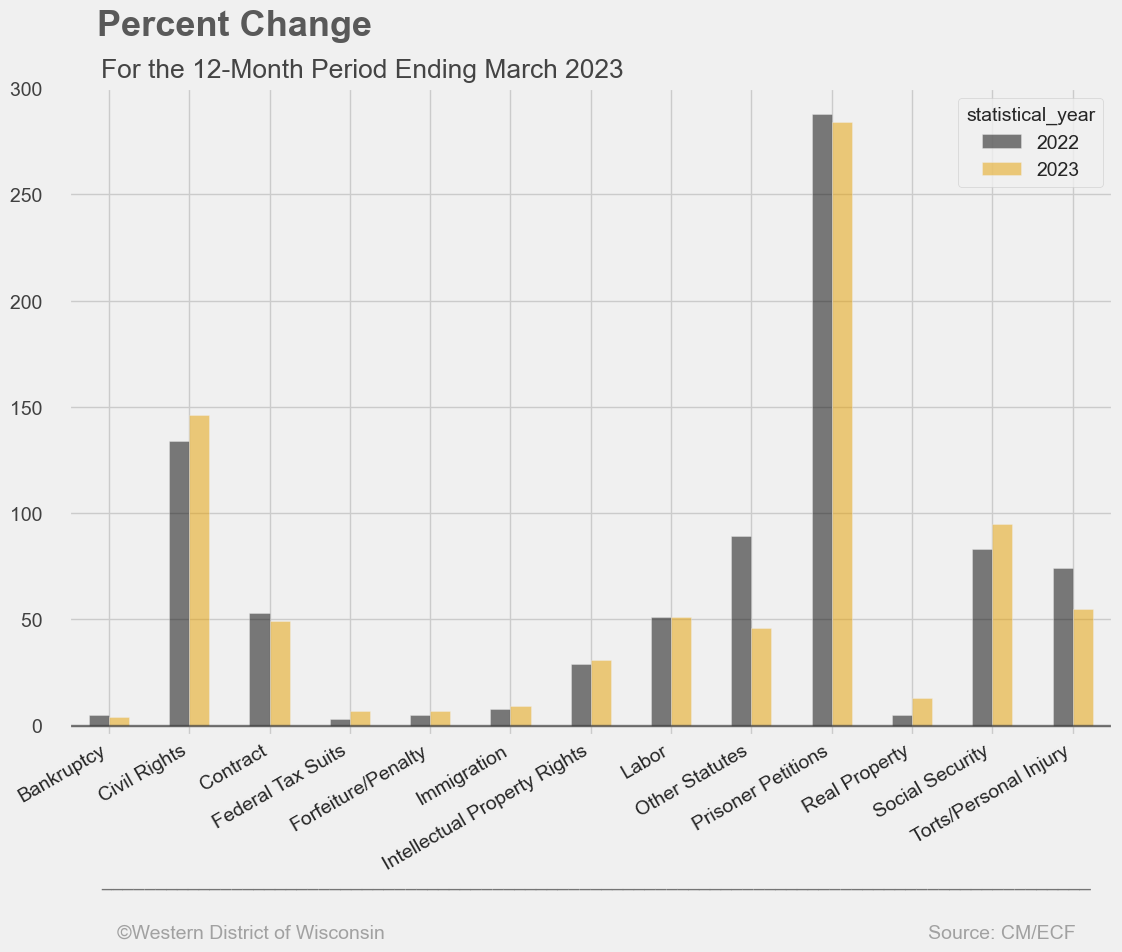

In [263]:
fte_graph = nos_totals_by_year.plot(kind='bar',
                                    figsize=(12, 8),
                                    alpha=0.5,
                                    color=colors)
ax = plt.gca()
fig = plt.gcf()
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.xticks(rotation=30, horizontalalignment="right")
plt.ylim(-5, 300)

ax.axhline(y=0, color='#414141', linewidth=1.7, alpha=.7)
ax.xaxis.label.set_visible(False)

# Y-labels to only these
ax.set_yticks([0, 50, 100, 150, 200, 250, 300])
ax.set_yticklabels(labels=['0    ','50    ', '100    ', '150    ','200    ','250    ', '300    '  ], fontsize=14, color='#414141')

# Title and Subtitle
ax.text(x=-.15, y=325, s="Percent Change", fontsize=26, weight='bold', alpha=.75)
ax.text(x=-.1, y=305, s="For the 12-Month Period Ending March 2023", fontsize=19, alpha=.85)

# Signature bar
ax.text(x=-.1, y=-75,
        s='___________________________________________________________________________________________',
        color='#414141', alpha=.7)
# Footer
ax.text(x=-.1, y=-100,
        s='   ©Western District of Wisconsin', fontsize=14, color='grey', alpha=.7)

ax.text(x=10, y=-100,
        s='   Source: CM/ECF', fontsize=14, color='grey', alpha=.7);

plt.savefig('/Users/jwt/PycharmProjects/cpi_program/WDBA2023/figures/percent change.png', dpi=300, bbox_inches='tight', transparent=True)

In [167]:
df

,case_number,judge,date_filed,date_reopened,date_terminated,NOS,IsProse,group,is_prose,statistical_year
0,3:21-cv-00217-jdp,jdp,2021-04-01,NaT,2022-07-26,751,n,Labor,counseled,2022
1,3:21-cv-00218-wmc,wmc,2021-04-01,NaT,2022-01-03,863,n,Social Security,counseled,2022
2,3:21-cv-00215-wmc,wmc,2021-04-01,NaT,2023-01-31,550,y,Prisoner Petitions,prose,2022
3,3:21-cv-00219-jdp,jdp,2021-04-01,NaT,2021-11-30,864,n,Social Security,counseled,2022
4,3:21-cv-00220-wmc,wmc,2021-04-02,NaT,2022-09-02,330,n,Torts/Personal Injury,counseled,2022
...,...,...,...,...,...,...,...,...,...,...
1619,3:20-cv-00098-wmc,wmc,2020-01-31,2023-01-25,2023-05-12,830,n,Intellectual Property Rights,counseled,2023
1620,3:20-cv-00019-jdp,jdp,2020-01-09,2023-02-13,NaT,830,n,Intellectual Property Rights,counseled,2023
1621,3:18-cv-01003-wmc,wmc,2018-12-04,2023-02-24,NaT,550,y,Prisoner Petitions,prose,2023
1622,3:18-cv-00116-wmc,wmc,2018-02-19,2023-03-24,NaT,550,y,Prisoner Petitions,prose,2023


In [168]:
df['group'].apply(lambda x: 'Prisoner Petitions' if x == 'Habeas Corpus' else x)

0                              Labor
1                    Social Security
2                 Prisoner Petitions
3                    Social Security
4              Torts/Personal Injury
                    ...             
1619    Intellectual Property Rights
1620    Intellectual Property Rights
1621              Prisoner Petitions
1622              Prisoner Petitions
1623                    Civil Rights
Name: group, Length: 1624, dtype: object

In [173]:
df

,case_number,judge,date_filed,date_reopened,date_terminated,NOS,IsProse,group,is_prose,statistical_year
0,3:21-cv-00217-jdp,jdp,2021-04-01,NaT,2022-07-26,751,n,Labor,counseled,2022
1,3:21-cv-00218-wmc,wmc,2021-04-01,NaT,2022-01-03,863,n,Social Security,counseled,2022
2,3:21-cv-00215-wmc,wmc,2021-04-01,NaT,2023-01-31,550,y,Prisoner Petitions,prose,2022
3,3:21-cv-00219-jdp,jdp,2021-04-01,NaT,2021-11-30,864,n,Social Security,counseled,2022
4,3:21-cv-00220-wmc,wmc,2021-04-02,NaT,2022-09-02,330,n,Torts/Personal Injury,counseled,2022
...,...,...,...,...,...,...,...,...,...,...
1619,3:20-cv-00098-wmc,wmc,2020-01-31,2023-01-25,2023-05-12,830,n,Intellectual Property Rights,counseled,2023
1620,3:20-cv-00019-jdp,jdp,2020-01-09,2023-02-13,NaT,830,n,Intellectual Property Rights,counseled,2023
1621,3:18-cv-01003-wmc,wmc,2018-12-04,2023-02-24,NaT,550,y,Prisoner Petitions,prose,2023
1622,3:18-cv-00116-wmc,wmc,2018-02-19,2023-03-24,NaT,550,y,Prisoner Petitions,prose,2023
